# **Analysis of All-Time NBA Player Career Statistics**

![Michael Jordan](https://i.imgur.com/UWAaqbw.jpeg)

Spring 2025 Data Science Project

Amanvir Parhar

Contributions: I worked on this project solo, so all contributions were made by me.

## **Introduction**

I’ve chosen to perform analysis on an [all-time NBA player statistics
dataset](https://www.kaggle.com/datasets/eoinamoore/historical-nba-data-and-player-box-scores/data?select=PlayerStatistics.csv) that I’ve found on Kaggle. I chose this dataset because I’m a fan of
the game of basketball, but I don’t know too much about the world of stats and
analytics surrounding the game. I’m interested in performing my own analyses
on this dataset of all-time NBA players to potentially detect patterns that exist within the data. This is an important undertaking, since finding and applying these patterns to new players who have just entered the league during this current season could help predict aspects of the future careers of these new players.

## **Data Curation**

As stated earlier, the dataset I've chosen to perform analysis upon is an [all-time NBA player statistics
dataset](https://www.kaggle.com/datasets/eoinamoore/historical-nba-data-and-player-box-scores/data?select=PlayerStatistics.csv) compiled by Eoin Moore. This dataset provides player stats/box scores since 1947 in the form of a CSV file called `PlayerStatistics.csv`.

### **Importing data**

We start by loading in the data into a Pandas DataFrame.

In [28]:
import pandas as pd
import numpy as np
from datetime import datetime
import string
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [29]:
stats_df = pd.read_csv("PlayerStatistics.csv")

<ipython-input-29-b3de3b129d34>:1: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  stats_df = pd.read_csv("PlayerStatistics.csv")


In [30]:
stats_df.head()

,firstName,lastName,personId,gameId,gameDate,playerteamCity,playerteamName,opponentteamCity,opponentteamName,gameType,...,threePointersPercentage,freeThrowsAttempted,freeThrowsMade,freeThrowsPercentage,reboundsDefensive,reboundsOffensive,reboundsTotal,foulsPersonal,turnovers,plusMinusPoints
0,Russell,Westbrook,201566,22401073,2025-03-28 21:00:00,Denver,Nuggets,Utah,Jazz,Regular Season,...,0.333,5.0,4.0,0.800,2.0,0.0,2.0,1.0,6.0,18.0
1,DeAndre,Jordan,201599,22401073,2025-03-28 21:00:00,Denver,Nuggets,Utah,Jazz,Regular Season,...,0.000,1.0,1.0,1.000,1.0,0.0,1.0,1.0,0.0,10.0
2,Aaron,Gordon,203932,22401073,2025-03-28 21:00:00,Denver,Nuggets,Utah,Jazz,Regular Season,...,0.500,4.0,1.0,0.250,5.0,0.0,5.0,1.0,2.0,24.0
3,Dario,Saric,203967,22401073,2025-03-28 21:00:00,Denver,Nuggets,Utah,Jazz,Regular Season,...,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0
4,Nikola,Jokic,203999,22401073,2025-03-28 21:00:00,Denver,Nuggets,Utah,Jazz,Regular Season,...,0.200,12.0,10.0,0.833,9.0,5.0,14.0,0.0,3.0,28.0


In [31]:
stats_df.dtypes

,0
firstName,object
lastName,object
personId,int64
gameId,int64
gameDate,object
playerteamCity,object
playerteamName,object
opponentteamCity,object
opponentteamName,object
gameType,object


### **Cleaning up data**

Now that we've loaded in the data, looked at the first few rows, and examined each of the columns, we can proceed with data cleaning.

#### **Removing unnecessary columns**

We'll start by removing unnecessary columns (i.e., columns that won't be used in our dataset).

In [32]:
stats_df = stats_df.drop(columns=['gameType', 'gameLabel', 'gameSubLabel', 'seriesGameNumber'])

#### **Dropping rows with null values, duplicates, and invalid values**

We'll now remove rows with null values as well as duplicate rows.

In [33]:
stats_df.dropna(inplace=True)
stats_df.drop_duplicates(subset=['personId', 'gameId'], inplace=True)
stats_df = stats_df[stats_df["numMinutes"] > 0]

#### **Correctly formatting dates**

Dates need to be properly converted so that they can be mainpulated later on (this is hard to do with date strings).

In [34]:
stats_df["gameDate"] = pd.to_datetime(stats_df["gameDate"])
stats_df["gameDate"]

,gameDate
0,2025-03-28 21:00:00
1,2025-03-28 21:00:00
2,2025-03-28 21:00:00
4,2025-03-28 21:00:00
6,2025-03-28 21:00:00
...,...
1611849,1951-11-11 19:00:00
1611850,1951-11-11 19:00:00
1611851,1951-11-11 19:00:00
1611852,1951-11-11 19:00:00


#### **Removing games from current (2024-25) season**

Since the current season is not complete, we should remove all player stats from games that happened during this season. Current season started in October 2024, so all games from October 2024 onwards will be removed.

In [35]:
nba_curr_season_start = pd.to_datetime("2024-10-01")
curr_season_df = stats_df[stats_df["gameDate"] >= nba_curr_season_start]
stats_df = stats_df[stats_df["gameDate"] < nba_curr_season_start]
stats_df["gameDate"]

,gameDate
31762,2024-06-17 20:30:00
31763,2024-06-17 20:30:00
31764,2024-06-17 20:30:00
31766,2024-06-17 20:30:00
31767,2024-06-17 20:30:00
...,...
1611849,1951-11-11 19:00:00
1611850,1951-11-11 19:00:00
1611851,1951-11-11 19:00:00
1611852,1951-11-11 19:00:00


## **Exploratory Data Analysis**

As a reminder, each of the columns as well as the shape of the dataset are shown below:

In [36]:
stats_df.shape

(1332690, 31)

In [37]:
stats_df.columns

Index(['firstName', 'lastName', 'personId', 'gameId', 'gameDate',
       'playerteamCity', 'playerteamName', 'opponentteamCity',
       'opponentteamName', 'win', 'home', 'numMinutes', 'points', 'assists',
       'blocks', 'steals', 'fieldGoalsAttempted', 'fieldGoalsMade',
       'fieldGoalsPercentage', 'threePointersAttempted', 'threePointersMade',
       'threePointersPercentage', 'freeThrowsAttempted', 'freeThrowsMade',
       'freeThrowsPercentage', 'reboundsDefensive', 'reboundsOffensive',
       'reboundsTotal', 'foulsPersonal', 'turnovers', 'plusMinusPoints'],
      dtype='object')

We'll now proceed with the three analyses done as part of Checkpoint #2:

### 1. **Calculating career averages for all players**

In [38]:
career_averages = stats_df.groupby(['personId', 'firstName', 'lastName']).agg({
    'personId': 'count',
    'points': 'mean',
    'assists': 'mean',
    'reboundsTotal': 'mean',
    'blocks': 'mean',
    'steals': 'mean',
    'plusMinusPoints': 'mean',
})

career_averages = career_averages.rename(columns={'personId': 'gamesPlayed'})

career_averages

,,,gamesPlayed,points,assists,reboundsTotal,blocks,steals,plusMinusPoints
personId,firstName,lastName,,,,,,,
2,Byron,Scott,1256,13.971338,2.483280,2.804936,0.243631,1.152866,0.213376
3,Grant,Long,1044,9.474138,1.700192,6.127395,0.360153,1.187739,-0.455939
7,Dan,Schayes,1200,7.743333,1.142500,4.985000,0.727500,0.459167,0.025833
9,Sedale,Threatt,1021,9.730656,3.784525,1.781587,0.140059,1.187071,-0.035260
12,Chris,King,105,6.600000,1.104762,2.961905,0.323810,0.714286,-0.133333
...,...,...,...,...,...,...,...,...,...
122683568,Vernon,Macklin,1,2.000000,0.000000,5.000000,0.000000,0.000000,0.000000
1962936250,Wesley,Matthews,2,14.000000,1.500000,1.500000,0.000000,0.500000,0.000000
1962936483,Jan,Vesely,1,7.000000,0.000000,3.000000,0.000000,2.000000,0.000000


In [39]:
career_averages.describe()

,gamesPlayed,points,assists,reboundsTotal,blocks,steals,plusMinusPoints
count,5009.000000,5009.000000,5009.000000,5009.000000,5009.000000,5009.000000,5009.000000
mean,266.059094,6.046470,1.346984,2.743463,0.254466,0.420528,-0.447015
std,340.635330,4.684213,1.359468,2.147648,0.355712,0.384710,1.807952
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-29.000000
25%,15.000000,2.706667,0.444444,1.250000,0.000000,0.102564,-0.870349
50%,95.000000,4.794521,0.953488,2.221519,0.140059,0.355576,0.000000
75%,434.000000,8.142857,1.815534,3.643264,0.338235,0.630000,0.000000
max,1863.000000,30.598721,11.394161,23.107759,3.533333,3.000000,15.000000


<ipython-input-40-bcc2cd75fec1>:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(career_averages["points"], labels=["All players"])


Text(0, 0.5, 'Points')

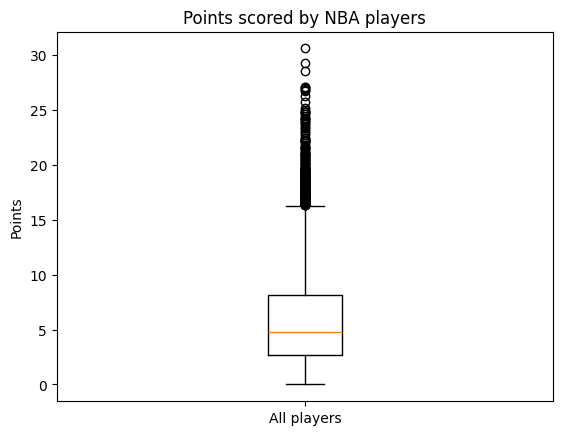

In [40]:
plt.boxplot(career_averages["points"], labels=["All players"])
plt.title("Points scored by NBA players")
plt.ylabel("Points")

In [41]:
print(f"Min players: {len(career_averages[career_averages['points'] == 0])}")
print(f"Max players: {len(career_averages[career_averages['points'] == career_averages['points'].max()])}")
career_averages[career_averages["points"] == career_averages["points"].max()]

Min players: 175
Max players: 1


,,,gamesPlayed,points,assists,reboundsTotal,blocks,steals,plusMinusPoints
personId,firstName,lastName,,,,,,,
893,Michael,Jordan,1251,30.598721,5.319744,6.254197,0.840128,2.310152,1.389289


**Conclusion**

> A basic exploration of the dataset containing information regarding the career stats of all NBA players shows that the average number of points scored per game (PPG) is 6.046470, with a high standard deviation of 4.684213. The distribution of this data is skewed right, since the median PPG (4.794521) is less than the mean (6.046470), indiciating that are outliers who have a average career PPG that is far higher than the central tendency/tendencies (this can be visually observed on the boxplot). There are many players who represent the minimum career PPG in this dataset (175 players have 0 PPG), but the player who has the highest career PPG is Michael Jordan, who averaged 30.598721 points per game throughout his entire career.

### 2. **Testing correlation between games played and points per game (PPG)**

p-value: 0.00000
Pearson coefficient (r): 0.69692



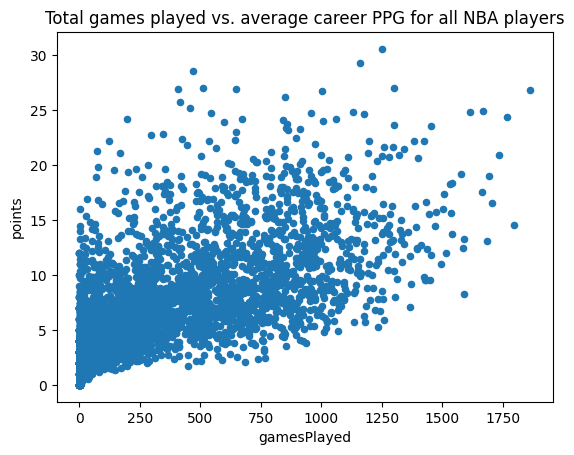

In [42]:
career_averages.plot.scatter(x="gamesPlayed", y="points")
plt.title("Total games played vs. average career PPG for all NBA players")

r_coefficient = scipy.stats.pearsonr(career_averages["gamesPlayed"], career_averages["points"])
print("p-value: " + "{:.5f}".format(r_coefficient.pvalue))
print("Pearson coefficient (r): " + "{:.5f}".format(r_coefficient.statistic) + "\n")

**Conclusion**:

> There is a strong positive correlation (r=0.69692) between the total number of games played and the average number of points scored per game (PPG) by NBA players. This conclusion is confirmed by the spread of data we see in the scatterplot above.

### 3. **Conducting hypothesis test to test home court advantage**

I will conduct a **paired t-test** to determine if players score significantly more points at home games in comparison to away games (assuming $\alpha=0.05$):

> HO: The average number of points scored by NBA players at home games is *not* statistically significantly different from the average number of points scored by NBA layers at away games.

> HA: The average number of points scored by NBA players at home games *is* significantly greater than the average number of points scored by NBA layers at away games.

<ipython-input-43-eb7671f90a9b>:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([home_games, away_games], labels=['Home games', 'Away games'])


Text(0, 0.5, 'Points')

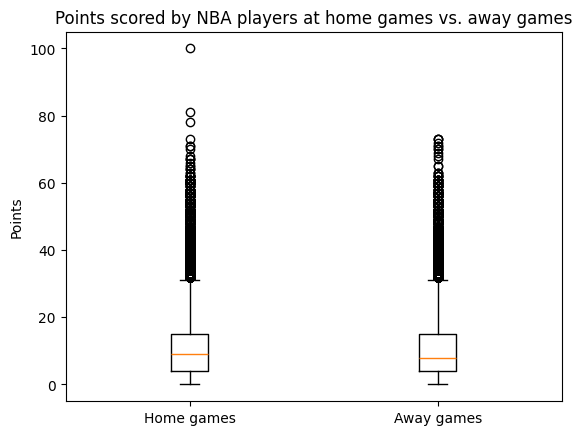

In [43]:
home_games = stats_df[stats_df['home'] == 1]['points']
away_games = stats_df[stats_df['home'] != 1]['points']

plt.boxplot([home_games, away_games], labels=['Home games', 'Away games'])
plt.title('Points scored by NBA players at home games vs. away games')
plt.ylabel('Points')

In [44]:
home_p_value = scipy.stats.ttest_ind(home_games, away_games, alternative='greater').pvalue.item()

home_p_value

4.361766890748162e-130

**Conclusion**:

> We reject the null hypothesis, because the resulting p-value is less than the significance level of 0.05. This means that the observed result is not likely to have occurred simply due to random chance. Therefore, the average number of points scored by NBA players at home games *is* significantly greater than the average number of points scored by NBA players at away games.

## **Primary Analysis**

After conducting my exploratory data analysis, I had the idea of training a multiple linear regression model on the career averages for the five "key stats" of *retired players* (points, rebounds, assists, steals, and blocks) to predict the length of a player's career (measured by the total number of games they have played). This data could then be used to make predictions about the career lengths of current/new players based on the career average of *their* five key stats.

For reference, here's how the career_averages data frame looks like:

In [45]:
career_averages.head()

,,,gamesPlayed,points,assists,reboundsTotal,blocks,steals,plusMinusPoints
personId,firstName,lastName,,,,,,,
2,Byron,Scott,1256,13.971338,2.483280,2.804936,0.243631,1.152866,0.213376
3,Grant,Long,1044,9.474138,1.700192,6.127395,0.360153,1.187739,-0.455939
7,Dan,Schayes,1200,7.743333,1.142500,4.985000,0.727500,0.459167,0.025833
9,Sedale,Threatt,1021,9.730656,3.784525,1.781587,0.140059,1.187071,-0.035260
12,Chris,King,105,6.600000,1.104762,2.961905,0.323810,0.714286,-0.133333


Before we proceed with creating the linear regression model, we must remove all current players, since their total number of games played is changing and not final. To do this, we can remove players who have played any number of games in the current 2024-25 NBA season.

In [46]:
curr_season_df.head()

,firstName,lastName,personId,gameId,gameDate,playerteamCity,playerteamName,opponentteamCity,opponentteamName,win,...,threePointersPercentage,freeThrowsAttempted,freeThrowsMade,freeThrowsPercentage,reboundsDefensive,reboundsOffensive,reboundsTotal,foulsPersonal,turnovers,plusMinusPoints
0,Russell,Westbrook,201566,22401073,2025-03-28 21:00:00,Denver,Nuggets,Utah,Jazz,1,...,0.333,5.0,4.0,0.800,2.0,0.0,2.0,1.0,6.0,18.0
1,DeAndre,Jordan,201599,22401073,2025-03-28 21:00:00,Denver,Nuggets,Utah,Jazz,1,...,0.000,1.0,1.0,1.000,1.0,0.0,1.0,1.0,0.0,10.0
2,Aaron,Gordon,203932,22401073,2025-03-28 21:00:00,Denver,Nuggets,Utah,Jazz,1,...,0.500,4.0,1.0,0.250,5.0,0.0,5.0,1.0,2.0,24.0
4,Nikola,Jokic,203999,22401073,2025-03-28 21:00:00,Denver,Nuggets,Utah,Jazz,1,...,0.200,12.0,10.0,0.833,9.0,5.0,14.0,0.0,3.0,28.0
6,Svi,Mykhailiuk,1629004,22401073,2025-03-28 21:00:00,Utah,Jazz,Denver,Nuggets,0,...,0.250,0.0,0.0,0.000,1.0,0.0,1.0,1.0,0.0,-16.0


In [47]:
print(career_averages.shape)
curr_season_players = curr_season_df['personId'].to_list()
career_averages = career_averages.drop(curr_season_players, errors='ignore')
print(career_averages.shape)

(5009, 7)
(4495, 7)


We can create `X`, which includes all of the five key stats (points, rebounds, assists, steals, and blocks), and `y`, the total number of games played, for our linear regression model.

In [48]:
X = career_averages[['points', 'reboundsTotal', 'assists', 'steals', 'blocks']]
y = career_averages['gamesPlayed']

We can then do a train/test split of our data, and then fit the model on the training data.

In [49]:
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Now, we can try the model on the test test and get the r^2 score, which indicates the correlation between the actual games played from the test set and our predictions of the number of games played.

In [50]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"r^2 score: {r2:.2f}")

r^2 score: 0.66


## **Visualization**

Here's a scatter plot that displays the actual total games played and the model's predictions:

Text(0, 0.5, 'Predicted Career Length')

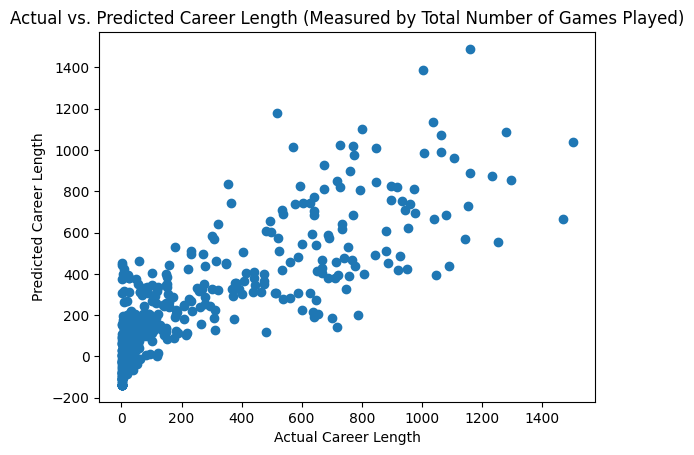

In [51]:
plt.title("Actual vs. Predicted Career Length (Measured by Total Number of Games Played)")
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Career Length")
plt.ylabel("Predicted Career Length")

The following visualization showcases the actual, real-world use-case of the model: it displays the predicted career lengths of players from the Kia Rookie Ladder, which is just the top three rookies of this current NBA season (i.e., players who just joined the league in the 2024-25 season) as chosen by critics and analysts. Note that, since we removed *all* players who played in the current season, there is no data leakage occurring.

First, we will calculate the rookies' career averages for the five key stats (same as their averages for the current season).

In [52]:
kia_rookie_ladder = curr_season_df[(curr_season_df['firstName'] + ' ' + curr_season_df['lastName']).isin(["Stephon Castle", "Zaccharie Risacher", "Alex Sarr"])]

rookie_career_averages = kia_rookie_ladder.groupby(['personId', 'firstName', 'lastName']).agg({
    'personId': 'count',
    'points': 'mean',
    'assists': 'mean',
    'reboundsTotal': 'mean',
    'blocks': 'mean',
    'steals': 'mean',
    'plusMinusPoints': 'mean',
})
rookie_career_averages = rookie_career_averages.rename(columns={'personId': 'gamesPlayed'})

rookie_career_averages

,,,gamesPlayed,points,assists,reboundsTotal,blocks,steals,plusMinusPoints
personId,firstName,lastName,,,,,,,
1642258,Zaccharie,Risacher,68,12.176471,1.264706,3.691176,0.470588,0.720588,-1.735294
1642259,Alex,Sarr,60,12.850000,2.283333,6.566667,1.566667,0.616667,-8.816667
1642264,Stephon,Castle,75,13.866667,3.693333,3.213333,0.240000,0.986667,-1.600000


Now, we can try to predict the rookies' expected career length based on their current stat averages. This information can then be displayed as a bar graph:

[574.95127542 895.12643408 710.93709781]


Text(0, 0.5, 'Predicted Career Length')

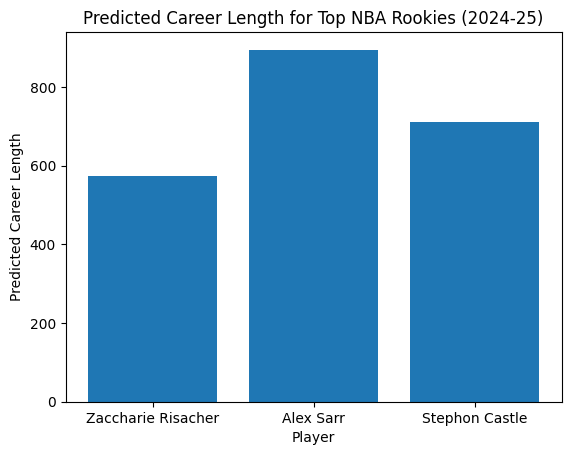

In [53]:
X_rookie = rookie_career_averages[['points', 'reboundsTotal', 'assists', 'steals', 'blocks']]
y_pred_rookie = model.predict(X_rookie)
print(y_pred_rookie)

plt.title("Predicted Career Length for Top NBA Rookies (2024-25)")
plt.bar([f + ' ' + l for (id, f, l) in rookie_career_averages.index], y_pred_rookie)
plt.xlabel("Player")
plt.ylabel("Predicted Career Length")

Based on the primary analysis, we can conclude that the five key stats serve as fairly strong indicators of a player's career length (the r^2 value from the predictions on the test set is 0.66). This means that our model can offer fairly accurate predictions on the careers of new players based on their running averages. From our predictions, it seems that Alex Sarr is the rookie predicted to play the most games in his career (895 games), which roughly translates to around 11 *full* NBA seasons.

## **Insights and Conclusions**

I hope that this analysis of NBA data was insightful and effectively showcased how approaching a large dataset (300+ MB) does not have to be a daunting task! Additionally, I hope that you were able to see how Pandas makes it easy to maniuplate the original data by eliminating rows and columns in the tabular data that are not necessary. Lastly, I hope that the the regression analysis displayed how machine learning can be utilized to detect and understand important trends in the dataset.